This dataset is an example of how cross validation and random forest are applied to classify the the expected predictor to two categories. One is higher income; people with annual income salary more than 50k per year. The other is anyone in which their income is below 50k. There are 15 variables to come with the dataset. They are belong to factor and numeric variables. To analyse this dataset, first a data exploration analysis will be carried on, then we will clean the data then use caret package to interpret and predict this classification case. 

In [3]:
library(ggplot2)
library(dplyr)
library(data.table)

adult <- fread('http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.data', data.table = F)


colnames(adult) <- c('age', 'workclass', 'fnlwgt', 'education', 
                     'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                     'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income')

str(adult)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last



'data.frame':	32561 obs. of  15 variables:
 $ age           : int  39 50 38 53 28 37 49 52 31 42 ...
 $ workclass     : chr  "State-gov" "Self-emp-not-inc" "Private" "Private" ...
 $ fnlwgt        : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education     : chr  "Bachelors" "Bachelors" "HS-grad" "11th" ...
 $ education_num : int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital_status: chr  "Never-married" "Married-civ-spouse" "Divorced" "Married-civ-spouse" ...
 $ occupation    : chr  "Adm-clerical" "Exec-managerial" "Handlers-cleaners" "Handlers-cleaners" ...
 $ relationship  : chr  "Not-in-family" "Husband" "Not-in-family" "Husband" ...
 $ race          : chr  "White" "White" "White" "Black" ...
 $ sex           : chr  "Male" "Male" "Male" "Male" ...
 $ capital_gain  : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital_loss  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours_per_week: int  40 13 40 40 40 40 16 45 50 40 ...
 $ native_country: chr  "United-States" "Uni

Using the fread function to read the table. Using data.table = F in fread function to turn off the this option, because we just want to read the table and import the data to R as dataframe. 

To process further we need to clean the data first. Notice that "?" in the data indicates NA value, we need to trasfrom this to NA. 

In [4]:
numcols = colnames(dplyr::select_if(adult, is.numeric))
charcols= colnames(dplyr::select_if(adult, is.character))

#replace ? to NA
for(i in 1:ncol(adult)){
  
  adult[,i] = ifelse(adult[,i] == '?', NA, adult[,i])
} 


sapply ( adult[,numcols],function(x) sum(is.na(x)) )

age         fnlwgt  education_num   capital_gain   capital_loss 
             0              0              0              0              0 
hours_per_week 
             0

In [5]:

sapply ( adult[,charcols],function(x) sum(is.na(x)) )

workclass      education marital_status     occupation   relationship 
          1836              0              0           1843              0 
          race            sex native_country         income 
             0              0            583              0

Using sapply to check NA value in each column of the dataset. We notice that all of the NA values come from factor columns. For the simplicity of this demonstration, we drop those rows that has NA values. 

In [6]:
adult = adult[complete.cases(adult), ]

Explore the data: 
We have divided our data into two categories, for those which are numeric and for those which are factors. We use summary function in R to give a quick look at their mean, standard, median, deviation, range. 


In [7]:
summary(adult[,numcols])

      age            fnlwgt        education_num    capital_gain  
 Min.   :17.00   Min.   :  13769   Min.   : 1.00   Min.   :    0  
 1st Qu.:28.00   1st Qu.: 117627   1st Qu.: 9.00   1st Qu.:    0  
 Median :37.00   Median : 178425   Median :10.00   Median :    0  
 Mean   :38.44   Mean   : 189794   Mean   :10.12   Mean   : 1092  
 3rd Qu.:47.00   3rd Qu.: 237629   3rd Qu.:13.00   3rd Qu.:    0  
 Max.   :90.00   Max.   :1484705   Max.   :16.00   Max.   :99999  
  capital_loss     hours_per_week 
 Min.   :   0.00   Min.   : 1.00  
 1st Qu.:   0.00   1st Qu.:40.00  
 Median :   0.00   Median :40.00  
 Mean   :  88.37   Mean   :40.93  
 3rd Qu.:   0.00   3rd Qu.:45.00  
 Max.   :4356.00   Max.   :99.00  

For factor variables, we create a function to count its frequency and percentage of each factor. To achieve, we import the libray knitr.

In [24]:
library(knitr)
all_table= function(x, y = adult$income){
  
  
  mt<-as.matrix(table(as.factor(x), as.factor(y)))
  count_cat<-as.matrix(table(x))
  colnames(count_cat)= "count_cat"
  mt= cbind(mt,count_cat)
  pct_total = round((mt[,3]/sum(mt[,3]))*100,2)
  pct_cat_low = round((mt[,1]/mt[,3])*100,2)
  pct_cat_high=round((mt[,2]/mt[,3])*100,2)
  mt= cbind(mt,pct_total,pct_cat_low,pct_cat_high)
 print(kable(mt))
}
for (col in charcols) {
  print(col)
  all_table(adult[, col])
}


[1] "workclass"


|                 | <=50K| >50K| count_cat| pct_total| pct_cat_low| pct_cat_high|
|:----------------|-----:|----:|---------:|---------:|-----------:|------------:|
|Federal-gov      |   578|  365|       943|      3.13|       61.29|        38.71|
|Local-gov        |  1458|  609|      2067|      6.85|       70.54|        29.46|
|Private          | 17410| 4876|     22286|     73.89|       78.12|        21.88|
|Self-emp-inc     |   474|  600|      1074|      3.56|       44.13|        55.87|
|Self-emp-not-inc |  1785|  714|      2499|      8.29|       71.43|        28.57|
|State-gov        |   935|  344|      1279|      4.24|       73.10|        26.90|
|Without-pay      |    14|    0|        14|      0.05|      100.00|         0.00|
[1] "education"


|             | <=50K| >50K| count_cat| pct_total| pct_cat_low| pct_cat_high|
|:------------|-----:|----:|---------:|---------:|-----------:|------------:|
|10th         |   761|   59|       820|      2.72|       92.80|       

From those tables above, we have some conclusions: 

-For the native_country variable, although there is a significant increase in terms of people earn more than 50K per year for the native US; however, other minorities does not account significantly in the case of proportion margin. We could comfortably exclude the variable out of our data, it is confirmed again later in our inspection in varImp from our model. 

-Race, again, shares the similarity with native_country

-Education, martital_status and relationship show more relevant connection to the income earning.


To visualise this dataset, we set up some functions to auto plot numeric variables compared to income category. 

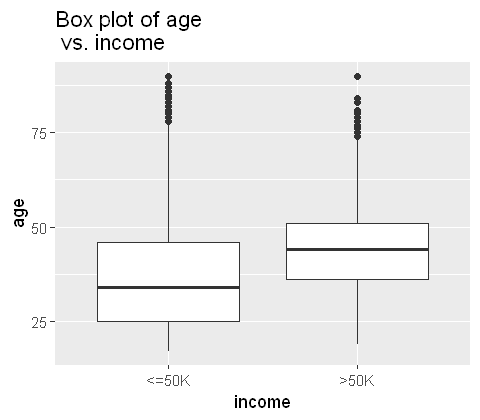

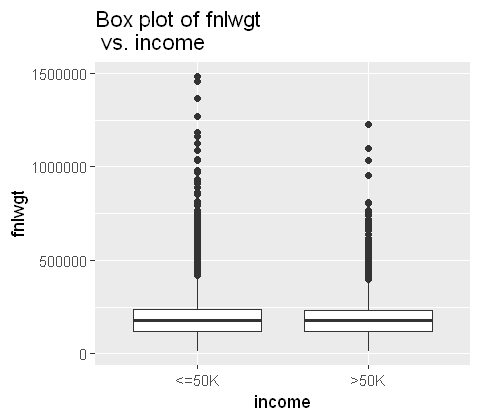

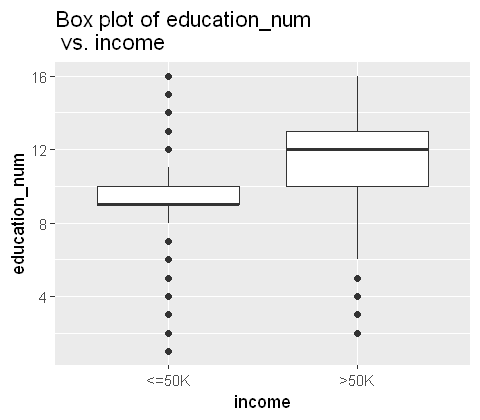

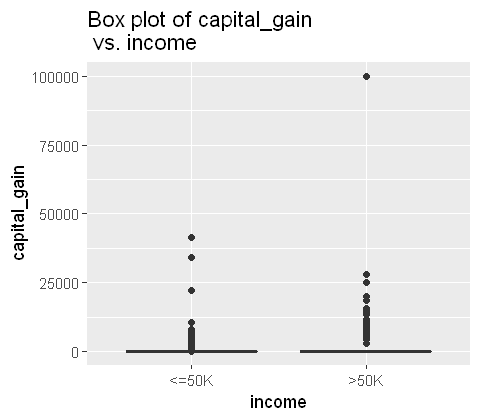

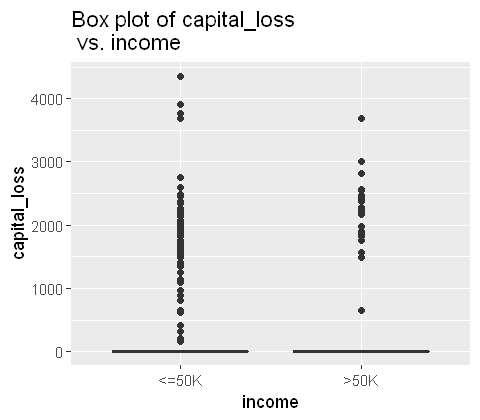

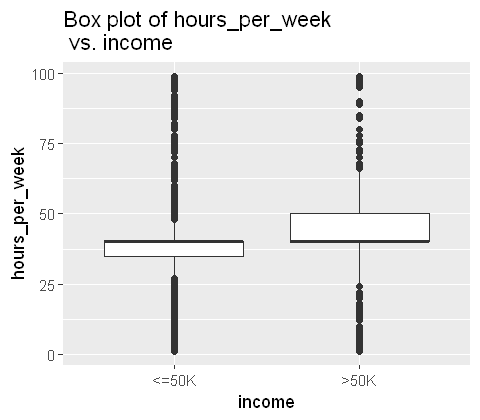

In [3]:
plot_box = function(df, cols, col_x = 'income'){
  options(repr.plot.width=4, repr.plot.height=3.5) # Set the initial plot area dimensions
  for(col in cols){
    p = ggplot(df, aes_string(col_x, col)) + 
      geom_boxplot() +
      ggtitle(paste('Box plot of', col, '\n vs.', col_x))
    print(p)
  }
}

plot_box(adult, numcols)

Having a quick look, we could see that age, education_num, hours_per_week have higher relevancy than fnlwgt, capital gain, capital loss. 

- Fnlwgt show noticeable outliers in the dataset.
- Capital gain and lost, all have their mean and median equal to 0, and they have many unique value for the higher values. 

Now, we explore the relationship between those factor variables and our predictor variable.

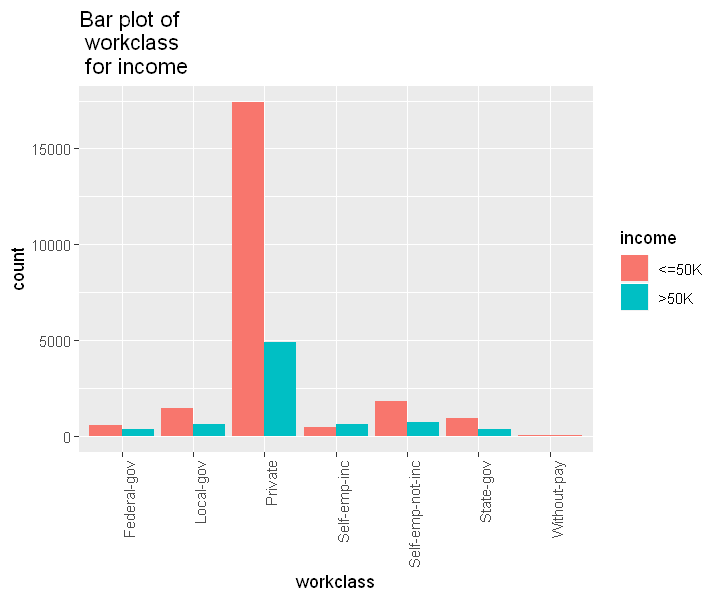

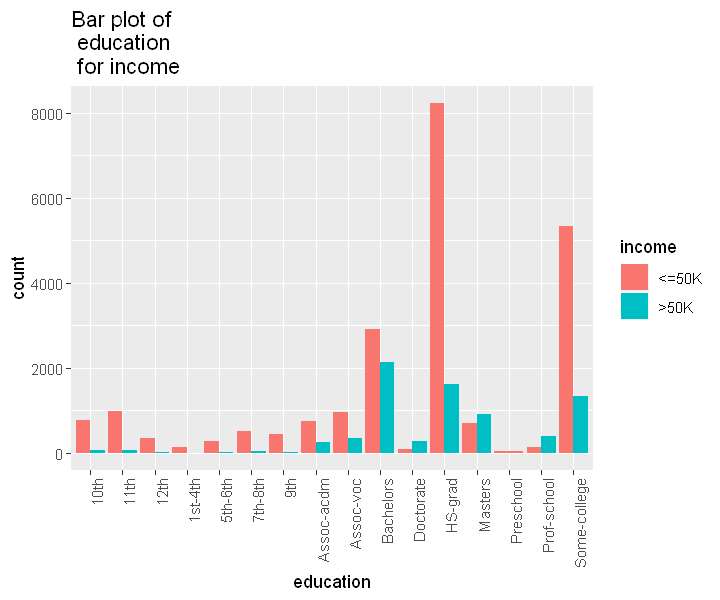

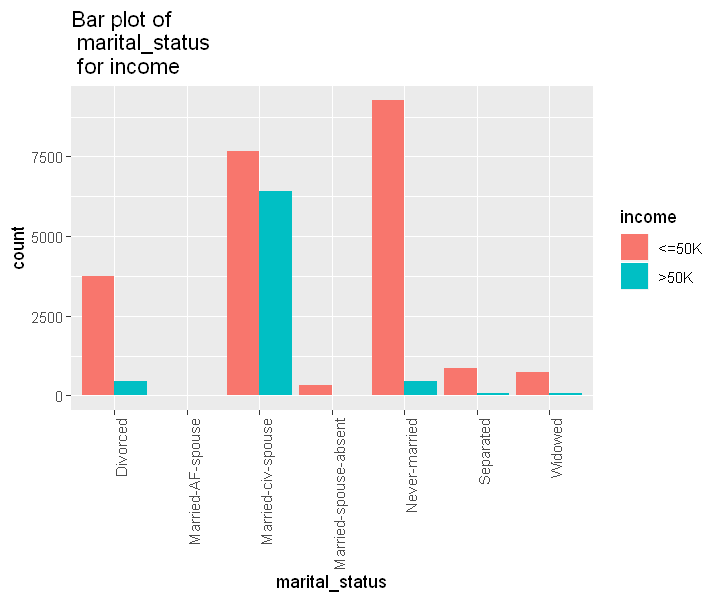

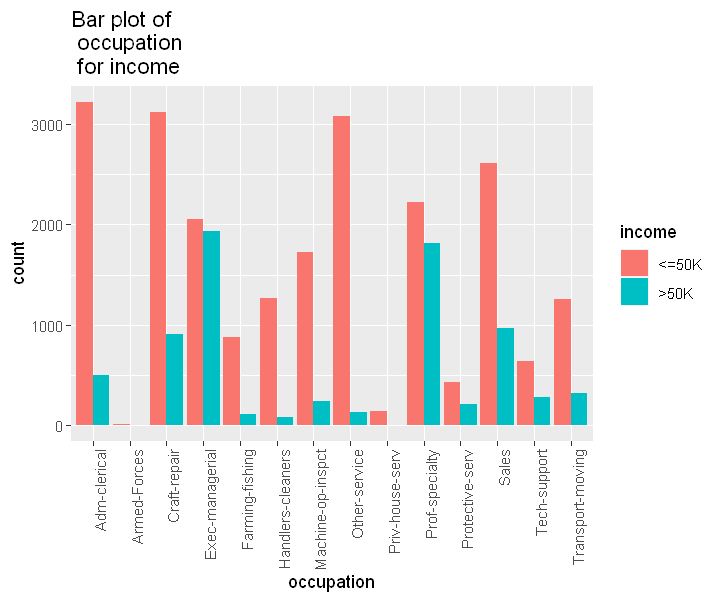

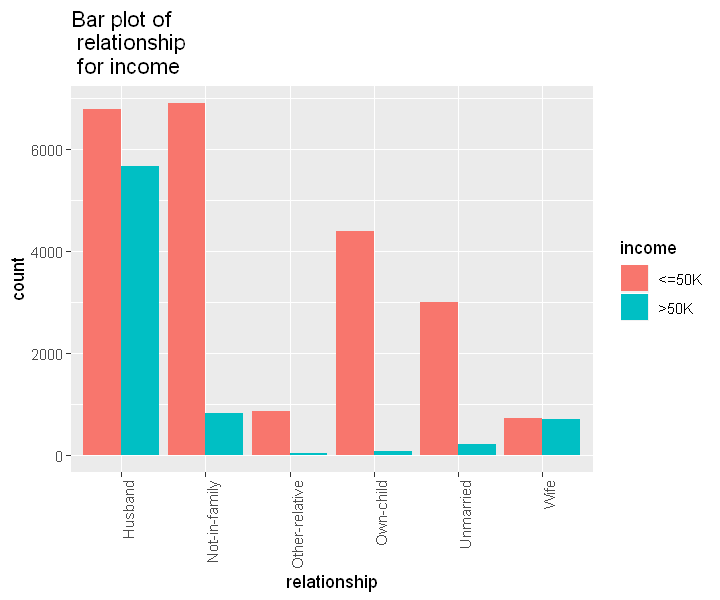

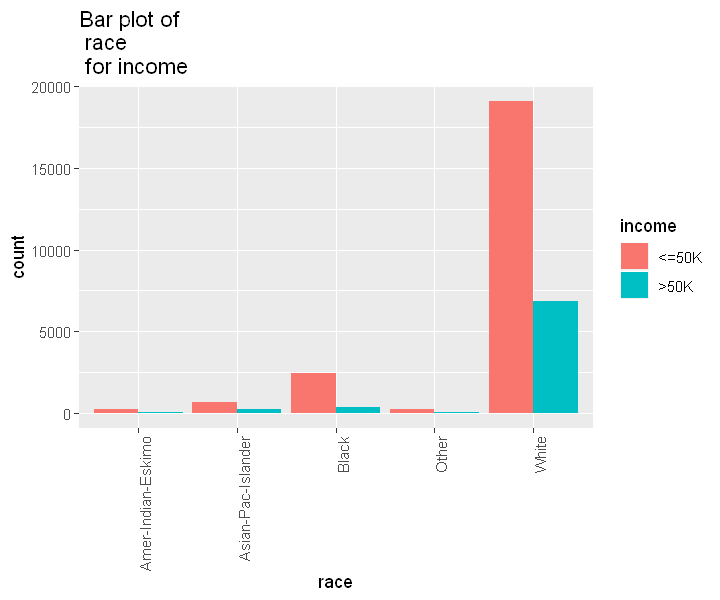

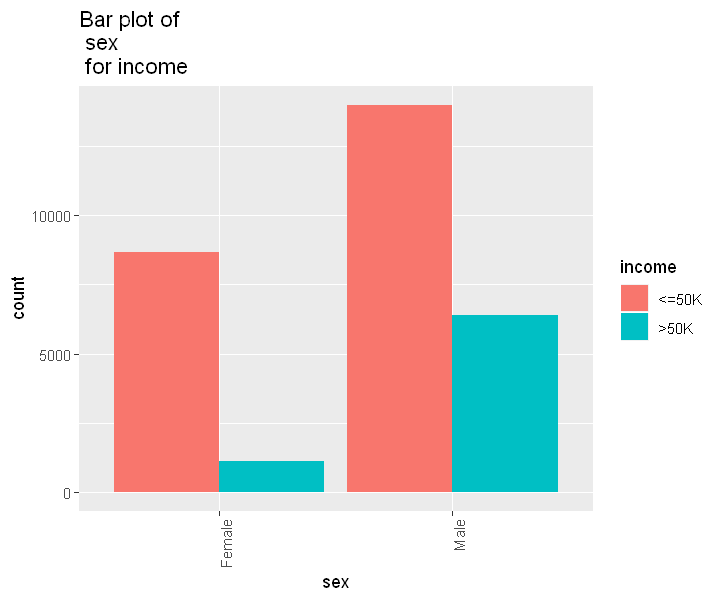

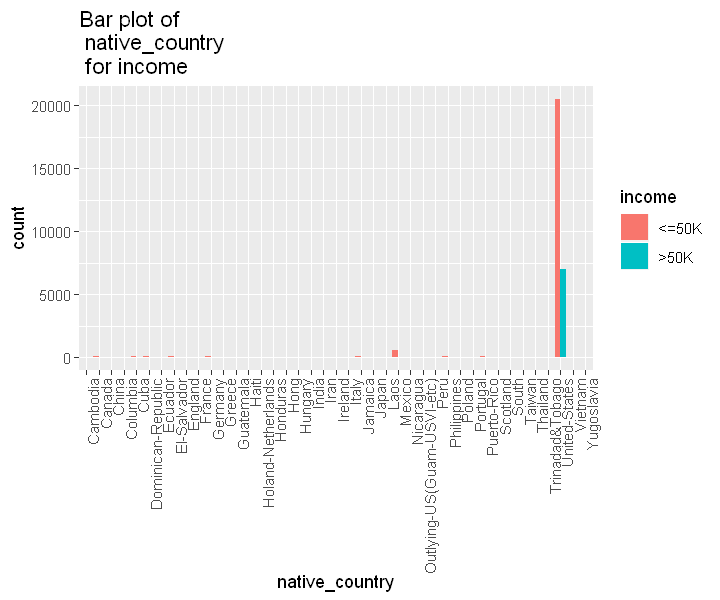

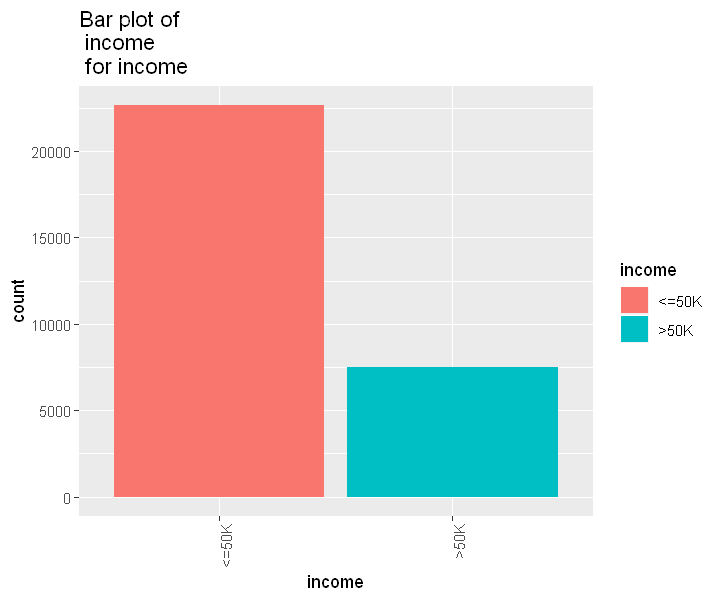

In [15]:
plot_bars2 = function(df, catcols){
  options(repr.plot.width=6, repr.plot.height=5) # Set the initial plot area dimensions
  for(col in catcols){
    p=ggplot(df, aes_string(x=col)) + 
      geom_bar(aes(fill =income) ,position = "dodge")+
      ggtitle(paste('Bar plot of \n', col, '\n for income')) +  
      theme(axis.text.x = element_text(angle = 90, hjust = 1))
  print(p)
  }
}

plot_bars2(adult,charcols)

From the plots, we identify some of noticeably important factors such as marital status, relationship and sex; race and native country appear to be less relevant to income response. 

We will use cross validation approach to build and test our data with caret package; however, it will take a lot of time to process the data considering the size of this dataset. For demonstration, we will only use 20% of data. To apply this, we need to install and library the package caret. 

In [ ]:
library(repr)
library(dplyr)
library(caret)
library(randomForest)
library(MLmetrics)


library(lattice)
library(caret)

To process further in building the model, we need to scale and centre those numeric variables (using preProcess and predict function). 
Change the name of income to "low" or "high" becuase symbols "<=" is not acceptable for name in factor. 
Then we will create data partition for out data based on 20/80 ration

In [16]:



preProcValues= preProcess(adult[, numcols], 
                          method = c("center", "scale"))
adult[, numcols]= predict(preProcValues, adult[, numcols])


adult$income<- ifelse(adult$income == "<=50K","low", "high")

for (col in charcols) {
  adult[, col]= as.factor(adult[, col])
}



ERROR: Error in preProcess(adult[, numcols], method = c("center", "scale")): could not find function "preProcess"


In [15]:
set.seed(124)
index= createDataPartition(adult$income,p=0.2, list = F)
d= adult[index,]

In [16]:
weights = ifelse(d$income == "low", 0.9, 0.1)

fitControl <- trainControl(method = "cv",
                           number = 5,
                           returnResamp="all",
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary)

paraGrid = expand.grid(mtry = c(5, 10, 15))
set.seed(1234)
rf.fit_inside = train(income~., 
                      data = d,
                      method = "rf", 
                      trControl = fitControl,
                      tuneGrid = paraGrid,
                      weights = weights,
                      metric = "ROC") 
print(rf.fit_inside)

Random Forest 

6033 samples
  14 predictor
   2 classes: 'high', 'low' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4827, 4827, 4826, 4825, 4827 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   5    0.8885264  0.5153023  0.9492371
  10    0.8992491  0.6065338  0.9359948
  15    0.9018481  0.6285006  0.9326830

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 15.


To confirm our expection on those important and unnecessary variables, we use varImp to plot the model out base on important level

rf variable importance

  only 20 most important variables shown (out of 96)

                                 Overall
marital_statusMarried-civ-spouse 100.000
age                               89.652
capital_gain                      89.634
fnlwgt                            75.864
education_num                     74.976
hours_per_week                    58.441
marital_statusNever-married       32.330
capital_loss                      25.684
occupationExec-managerial         20.552
sexMale                           16.800
relationshipNot-in-family         13.630
occupationProf-specialty          13.157
workclassPrivate                  10.959
relationshipOwn-child              8.978
relationshipWife                   8.682
educationBachelors                 8.557
workclassSelf-emp-not-inc          8.285
educationMasters                   7.888
occupationSales                    7.741
relationshipUnmarried              7.567


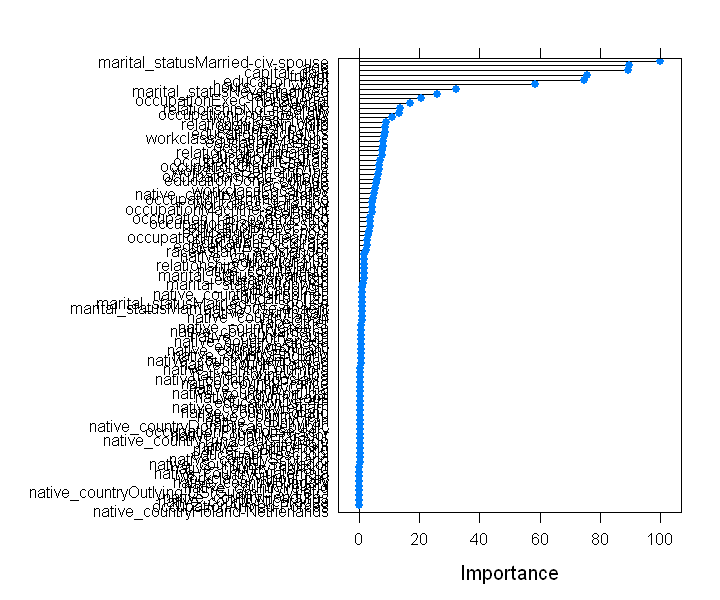

In [17]:

var_imp = varImp(rf.fit_inside)
print(var_imp)
plot(var_imp)


It is confirmed that race and native_country should be out of the picture in this case. We deselect these two factors and now we can put into our model. We still set our tuneGrid as mtry (5,10,15) to see the best number of variables to put into the model

In [18]:
vaReduced <- colnames(subset(d, select = -c(native_country, race,fnlwgt)))

d1<-d[, vaReduced]
weights = ifelse(d1$income == "low", 0.9, 0.1)

fitControl <- trainControl(method = "cv",
                           number = 5,# set 5 fold cross validation
                           returnResamp="all",
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary)
paraGrid = expand.grid(mtry = c(5, 10, 15))
set.seed(1234)
rf.fit_inside1 = train(income~., 
                      data = d1,
                      method = "rf", #using random forest 
                      trControl = fitControl,
                      tuneGrid = paraGrid,
                      weights = weights,
                      metric = "ROC") 
print(rf.fit_inside1)

Random Forest 

6033 samples
  12 predictor
   2 classes: 'high', 'low' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4827, 4827, 4826, 4825, 4827 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   5    0.8961473  0.5972071  0.9373183
  10    0.9007890  0.6358117  0.9265032
  15    0.8988287  0.6264850  0.9225312

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 10.


The summarise we have based on the trainControl we set in previous stage in which we set summaryFunctio = twoClassSummary. 
This will call a metric depicting number of mtry, ROC, Sens and Spec. The optimimal value of mtry for the model is picked 
by our setting in metric from train fuction. 

Our model is built to predict a binomial outcome, hense, considering the nature of our predicting is to identify the category
a person belongs to, we choose ROC as the evaluation option for the function to choose on. However, it depends on situation,
wheather we value on the accurate prediction on true positive value or negative value, we could set the metric = "spec" or 
"sens". 

Spec is the ratio between the True postive that the model predicts right over the actual true, or TP/ (TP+FN). If we 
prioritise the TP over the TN, we should choose Sens. Scenario like to detect the spam emails or not, sensitivity is the priority than the Spec because the cost of detecting important email as spam is significantly higher than the opposite case. 

On the other hand, cases like fraud transactions from banking industry, Spec is prior than Sens cause the cost of not dectecting fraudelent actitivities causes much more damages than missing it. 

To visualise the concept above, here is another way to demonstrate it. 

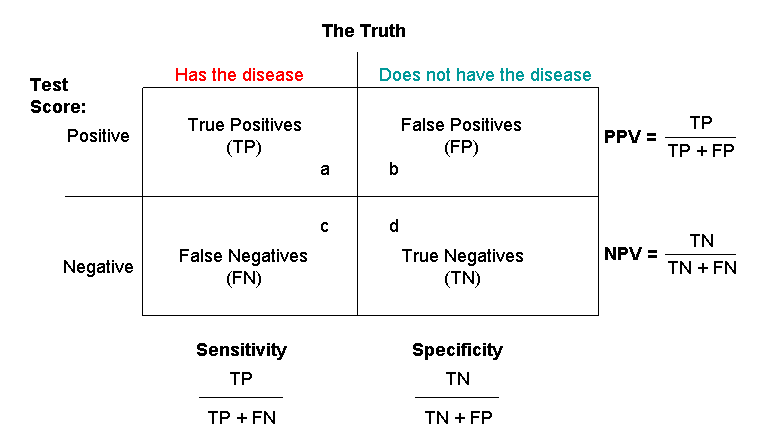

WE can set: summaryFunction = prSummary in trainControl so the final summary will let the final model optimising its best value base on AUC, precision and recall. 
When the cost of fase positive is high, we should value the precision rate over the recall, such spam emails. 

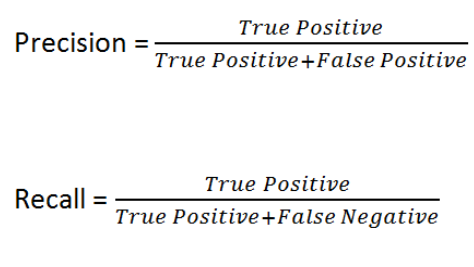

let's test on outside loop by setting our paraGrid to the selected mtry. To do that, we set call out the mtry by using this syntax: name_of_the_model_$finalModel$mtry, then put it in out tuneGrid and evalute our result. 

In [19]:
paramGrid <- expand.grid(mtry = c(rf.fit_inside1$finalModel$mtry))

set.seed(5678)
rf_fit_outside_pr <- train(income ~ ., 
                           data = d1,  
                           method = "rf", # Random forest model 
                           trControl = fitControl, 
                           tuneGrid = paramGrid, 
                           weights = weights,
                           metric = "ROC")
print(rf_fit_outside_pr)
print_metrics = function(mod){
  means = c(apply(mod$resample[,1:4], 2, mean), mtry = 10, Resample = 'Mean')
  stds = c(apply(mod$resample[,1:4], 2, sd), mtry =10, Resample = 'STD')
  out = rbind(mod$resample, means, stds)
  out[,1:4] = lapply(out[,1:4], function(x) round(as.numeric(x), 3))
  out
}
print_metrics(rf_fit_outside_pr)

Random Forest 

6033 samples
  12 predictor
   2 classes: 'high', 'low' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4827, 4826, 4827, 4825, 4827 
Resampling results:

  ROC        Sens       Spec     
  0.9006101  0.6298494  0.9254031

Tuning parameter 'mtry' was held constant at a value of 10


ROC,Sens,Spec,mtry,Resample
0.912,0.660,0.934,10,Fold1
0.881,0.581,0.925,10,Fold2
0.898,0.627,0.908,10,Fold3
0.903,0.645,0.924,10,Fold4
0.909,0.637,0.936,10,Fold5
0.901,0.630,0.925,10,10
0.013,0.030,0.011,0,10


As can be seen from the metric, out std is way samller than our mean of all those resamples. It is justified to use this approach. 


Notice that there are many ways to improve this process. First, education_num can be categoried into few factors instead 
leaving too many factors in one level. It will speed to the process in buliding models. 

We could drop the race and country factor after our explorable analysis, it can be clearly seen from the plot that it has 
close-to-zero connection between these two variables to the prediction income variable. 

We can use gplots to quickly sketting out the ration of each categorical variable compared to income. 


Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



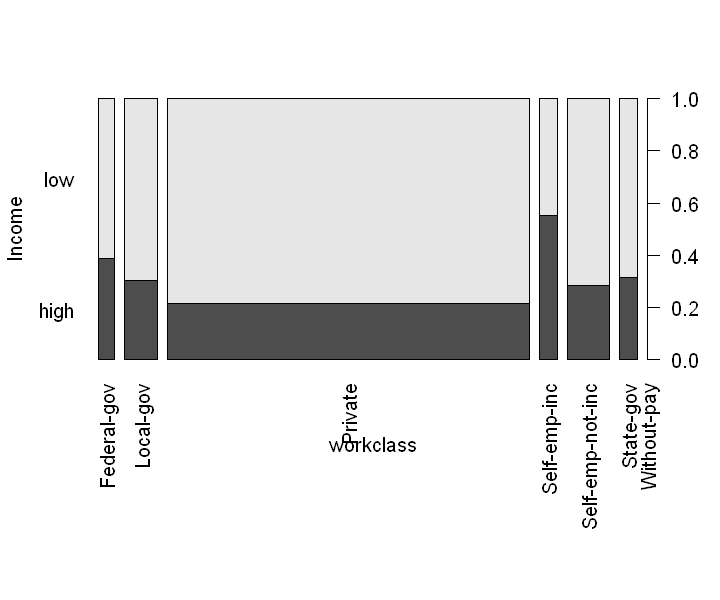

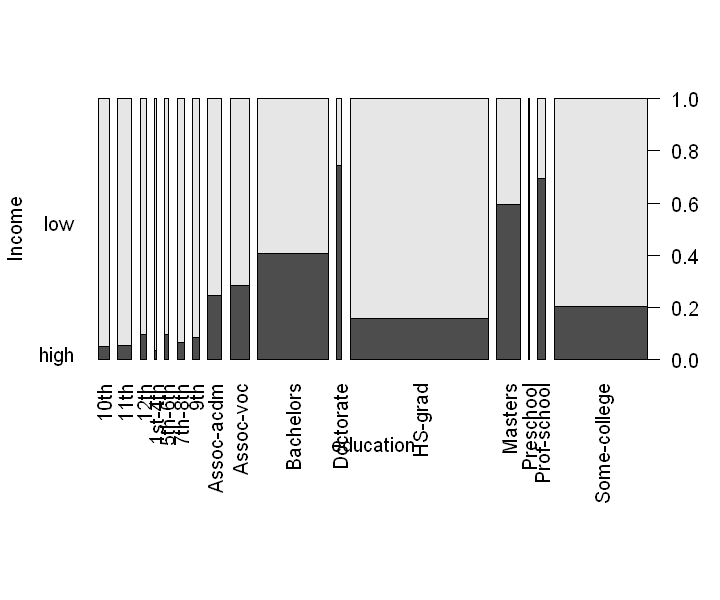

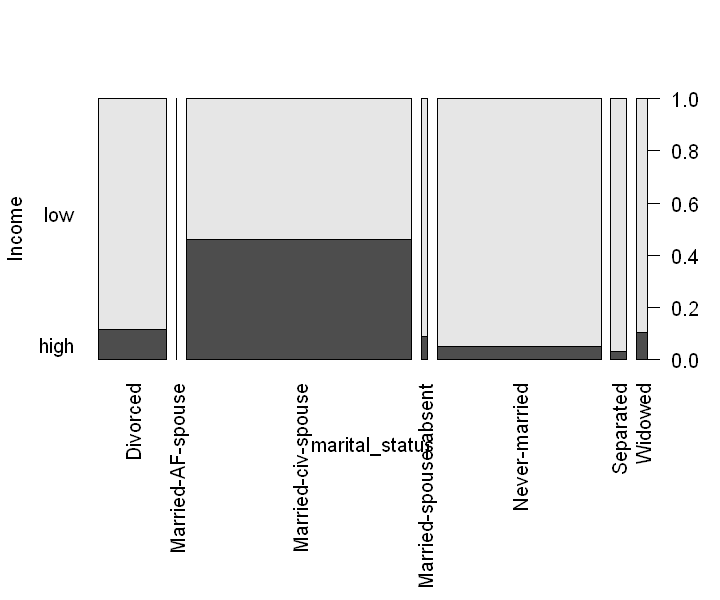

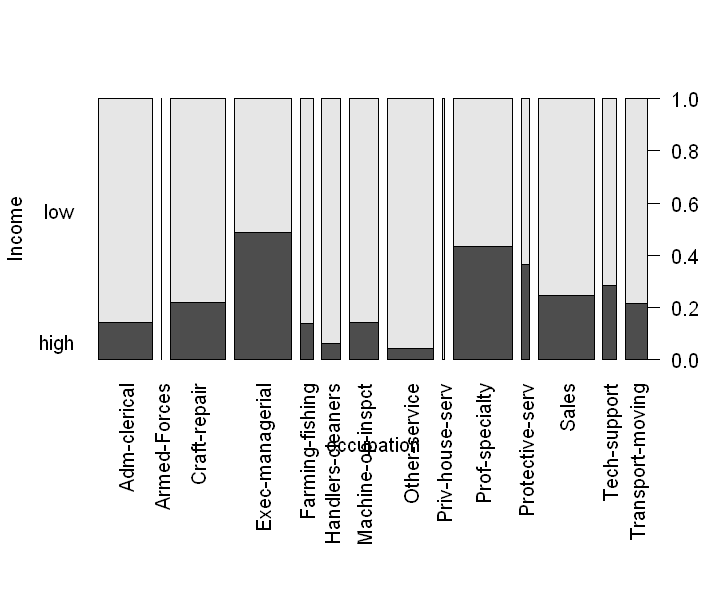

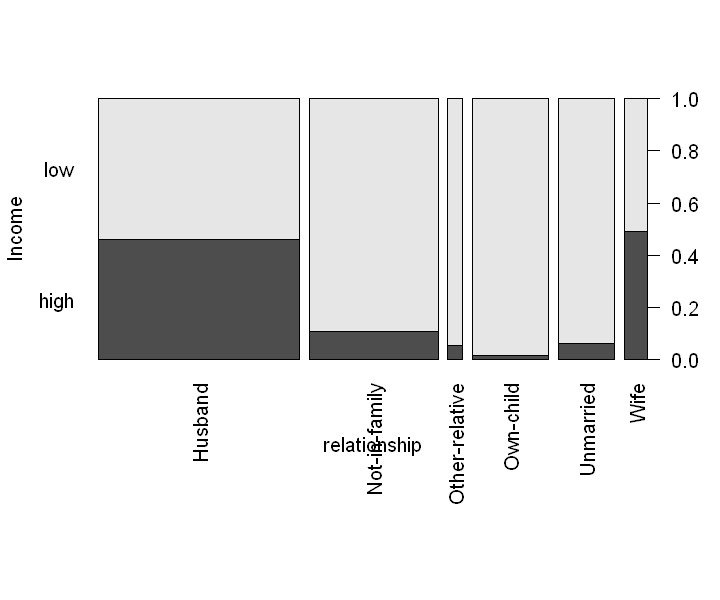

null device 
          1

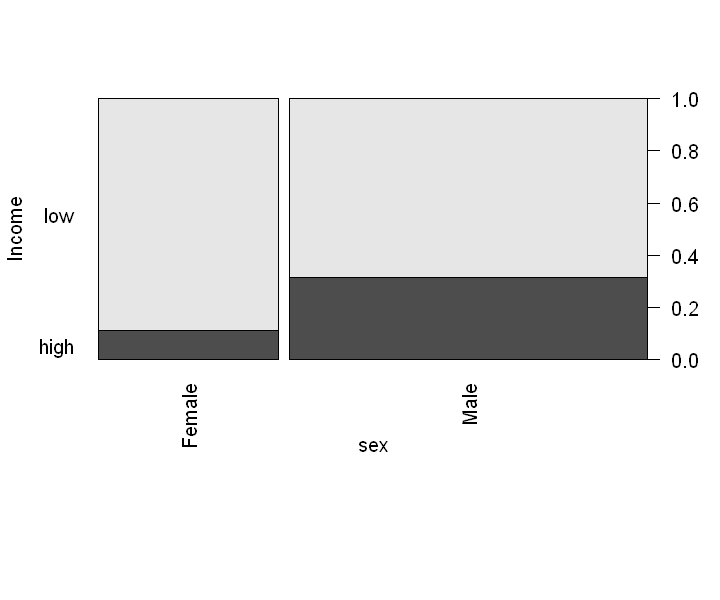

In [22]:
library(gplots)

charcolsD1=colnames(dplyr::select_if(d1, is.factor))
par(mfrow= c(1,1))
 
gplotVar<- function(var, data){
  # adjusting the margin using par(mai= c(bottom, left, top,right ))
  par(mai=c(2,0.82,0.82,0.6))
  #set the lable to rotate vertically
  par(las =2)
  for (col in var) {
    plot(d1[,col], data$income, xlab=col,
         ylab = "Income")
  }
  dev.off() 
}
gplotVar(charcolsD1, d1)
